In [55]:
# Imports
import os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patheffects as pe
import seaborn as sns
sns.set_theme(style="whitegrid")

In [56]:
# Config
SORT_BY_OVERALL_MEAN = True     # sort equipment types by their overall mean accuracy across durations
LABEL_BARS = True               # write numeric values on top of bars
SHOW_ERROR_BARS = True          # show standard error bars (std / sqrt(n))
PERCENT_LABEL_DECIMALS = 1      # decimals for bar labels
Y_LIMIT = (0, 100)              # y-axis limits in percent
SAVE_FIG_PATH = None            # e.g., "accuracy_grouped_bars.png" or None to skip
EXPORT_AGG_CSV_PATH = None      # e.g., "agg_accuracy_by_equipment_duration.csv" or None to skip
USE_PLOTLY_IF_AVAILABLE = False # try Plotly (interactive); falls back to Matplotlib if not available
NEAR_TOP_DELTA = 2.0
LABEL_FONT_SIZE = 8          # <-- new: smaller label font
LABEL_OUTLINE_WIDTH = 0    # optional: thinner outline for readability
SMOOTH_WINDOW_FRAMES = 21   # rolling window for smoothing (odd number recommended)
Y_LIMIT = (0, 100)
SAVE_FIG_PATH = None

# Human-readable equipment names
LABEL_MAP = {
    "Gymnastik": "Exercise ball",
    "schwamm": "blackboard eraser",
    "terabandMuster": "Teraband (trackingmarker)",
    "teraband": "Teraband (plain)",
}

# Read data

In [57]:
eval_data_path = './evaluation'
dirs = os.listdir(eval_data_path)
dirs.sort()

results = []

for eval_target in dirs:

    equipment_type, num_str, duration_str = eval_target.split('_')
    num = int(num_str)
    duration_s = int(duration_str.split('s')[0])


    target_path = f'{eval_data_path}/{eval_target}/analysis'
    if not os.path.exists(target_path):
        print(f'Could not find {target_path}')
        continue

    csv_path = os.path.join(target_path, 'metrics_per_frame.csv')
    json_path = os.path.join(target_path, 'metrics_summary.json')

    summary = {}
    if os.path.isfile(json_path):
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                summary = json.load(f)
        except Exception as e:
            print(f"Failed to read {json_path}: {e}")


        # Merge summary at top-level; meta keys override on collision
        entry = { # flatten fields from metrics_summary.json
            "equipment_type": equipment_type,
            "num": num,
            "duration_s": duration_s,
            "csv_path": csv_path,
            **summary
        }

        results.append(entry)

for elem in results:
    print(json.dumps(elem, indent=2, ensure_ascii=False, sort_keys=True))

{
  "average_accuracy_percent": 85.49753505958934,
  "correct_points_total": 71452,
  "csv_path": "./evaluation/Gymnastik_10_30s/analysis/metrics_per_frame.csv",
  "duration_s": 30,
  "equipment_type": "Gymnastik",
  "frames_analyzed": 900,
  "num": 10,
  "visible_points_total": 83572
}
{
  "average_accuracy_percent": 84.84617401043776,
  "correct_points_total": 71208,
  "csv_path": "./evaluation/Gymnastik_10_30s360/analysis/metrics_per_frame.csv",
  "duration_s": 30,
  "equipment_type": "Gymnastik",
  "frames_analyzed": 900,
  "num": 10,
  "visible_points_total": 83926
}
{
  "average_accuracy_percent": 90.74236232730104,
  "correct_points_total": 18653,
  "csv_path": "./evaluation/Gymnastik_1_5s/analysis/metrics_per_frame.csv",
  "duration_s": 5,
  "equipment_type": "Gymnastik",
  "frames_analyzed": 150,
  "num": 1,
  "visible_points_total": 20556
}
{
  "average_accuracy_percent": 91.33513646422425,
  "correct_points_total": 18573,
  "csv_path": "./evaluation/Gymnastik_1_5s360/analysi

# Analysis

1. bar graph "Average accuracy per Equiment type and clip duration

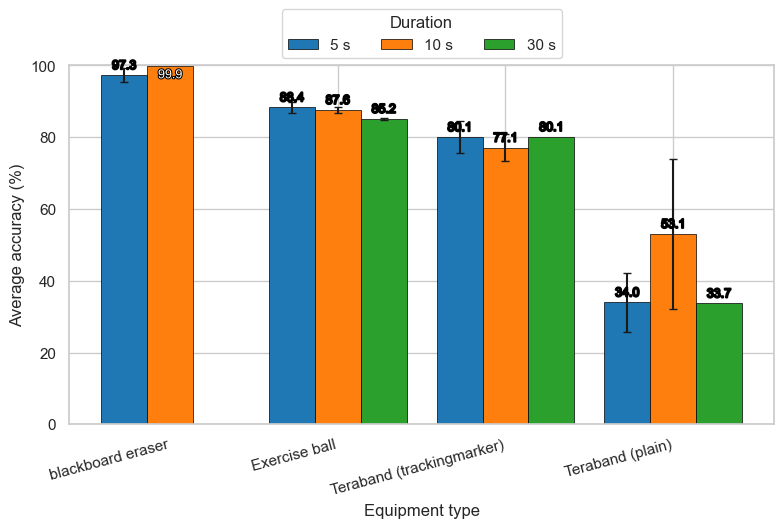

duration_s,5,10,30
equipment_type,,,
blackboard eraser,97.3,99.9,nan
Exercise ball,88.4,87.6,85.2
Teraband (trackingmarker),80.1,77.1,80.1
Teraband (plain),34.0,53.1,33.7


In [58]:
# DataFrame
df = pd.DataFrame(results)[["equipment_type", "duration_s", "average_accuracy_percent"]].copy()
df["duration_s"] = df["duration_s"].astype(int)
df["average_accuracy_percent"] = df["average_accuracy_percent"].astype(float)

# Apply readable equipment labels
df["equipment_type"] = df["equipment_type"].replace(LABEL_MAP)

# Aggregate: mean, std, count by (equipment_type, duration_s)
agg = (
    df.groupby(["equipment_type", "duration_s"])["average_accuracy_percent"]
      .agg(mean="mean", std="std", count="count")
      .reset_index()
)

# Pivot to wide for means and standard error
means_wide = agg.pivot(index="equipment_type", columns="duration_s", values="mean").sort_index()
stderr = (agg.assign(stderr=agg["std"] / np.sqrt(agg["count"].clip(lower=1))))
stderr_wide = stderr.pivot(index="equipment_type", columns="duration_s", values="stderr").reindex(means_wide.index)

# Sort columns (durations) ascending and optionally rows by overall mean
means_wide = means_wide.reindex(sorted(means_wide.columns), axis=1)
stderr_wide = stderr_wide.reindex(means_wide.columns, axis=1)

if SORT_BY_OVERALL_MEAN:
    order = means_wide.mean(axis=1).sort_values(ascending=False).index
    means_wide = means_wide.loc[order]
    stderr_wide = stderr_wide.loc[order]

# Optional: export aggregated table
if EXPORT_AGG_CSV_PATH:
    agg.sort_values(["equipment_type", "duration_s"]).to_csv(EXPORT_AGG_CSV_PATH, index=False)

# Try Plotly (optional)
fig_used_plotly = False
if USE_PLOTLY_IF_AVAILABLE:
    try:
        import plotly.graph_objects as go

        x_cats = list(means_wide.index)
        durations = list(means_wide.columns)
        fig = go.Figure()

        for j, d in enumerate(durations):
            y_vals = means_wide[d].values
            # dynamic textposition per point: put inside near top
            textpos = ["inside" if (v >= (Y_LIMIT[1] - NEAR_TOP_DELTA)) else "outside" for v in y_vals]
            textfont_color = ["white" if tp == "inside" else "black" for tp in textpos]


            fig.add_trace(go.Bar(
                x=x_cats, y=y_vals, name=f"{d} s",
                text=[f"{v:.{PERCENT_LABEL_DECIMALS}f}" for v in y_vals] if LABEL_BARS else None,
                textposition=textpos if LABEL_BARS else None,
                textfont=dict(                     # <-- edited
                    size=LABEL_FONT_SIZE,
                    color=textfont_color if LABEL_BARS else None
                ) if LABEL_BARS else None,
                error_y=dict(
                    type="data",
                    array=stderr_wide[d].values if SHOW_ERROR_BARS else None,
                    visible=SHOW_ERROR_BARS,
                    thickness=1.5, width=3
                )
            ))

        fig.update_layout(
            barmode="group",
            yaxis=dict(range=list(Y_LIMIT), title="Average accuracy (%)"),
            xaxis_title="Equipment type",
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5),
            margin=dict(t=60, b=80, l=60, r=20),
        )
        fig.show()
        fig_used_plotly = True
    except Exception:
        fig_used_plotly = False  # fall back to Matplotlib

# Matplotlib grouped bars (fallback or default)
if not fig_used_plotly:
    means = means_wide.to_numpy()
    errs = stderr_wide.to_numpy() if SHOW_ERROR_BARS else None

    n_groups, n_bars = means.shape
    x = np.arange(n_groups)
    total_width = 0.82
    bar_width = total_width / max(n_bars, 1)
    offsets = (np.arange(n_bars) - (n_bars - 1) / 2) * bar_width

    cmap = plt.get_cmap("tab10")
    colors = [cmap(i % 10) for i in range(n_bars)]

    fig, ax = plt.subplots(figsize=(max(8, n_groups * 0.9), 5 + 0.15 * n_bars))

    for j, (col, color) in enumerate(zip(means_wide.columns, colors)):
        y = means[:, j]
        yerr = errs[:, j] if (errs is not None and n_bars > 0) else None
        bars = ax.bar(
            x + offsets[j],
            y,
            width=bar_width,
            label=f"{col} s",
            color=color,
            edgecolor="black",
            linewidth=0.5,
            yerr=yerr if SHOW_ERROR_BARS else None,
            capsize=3 if SHOW_ERROR_BARS else 0,
        )

        # Smart labels: inside near top; outside otherwise
        if LABEL_BARS:
            for rect, val in zip(bars, y):
                if math.isnan(val):
                    continue
                label = f"{val:.{PERCENT_LABEL_DECIMALS}f}"
                near_top = (val >= (Y_LIMIT[1] - NEAR_TOP_DELTA))
                if near_top:
                    # place label inside the bar, slightly below the top
                    y_text = rect.get_height() - 1.0
                    va = "top"
                    color_txt = "white"
                else:
                    # place above the bar
                    y_text = rect.get_height() + 0.8
                    va = "bottom"
                    color_txt = "black"

                txt = ax.text(
                    rect.get_x() + rect.get_width() / 2,
                    y_text,
                    label,
                    ha="center",
                    va=va,
                    fontsize=9,
                    color=color_txt,
                )
                # Add outline for readability
                txt.set_path_effects([pe.withStroke(linewidth=1.5, foreground="black")])

    ax.set_xticks(x)
    ax.set_xticklabels(means_wide.index, rotation=15, ha="right")
    ax.set_ylim(*Y_LIMIT)
    ax.set_ylabel("Average accuracy (%)")
    ax.set_xlabel("Equipment type")

    # Move legend outside (top) to avoid any overlap
    ax.legend(
        title="Duration",
        ncols=min(n_bars, 4),
        frameon=True,
        loc="lower center",
        bbox_to_anchor=(0.5, 1.02),
        borderaxespad=0.0
    )

    # Extra top/bottom room for external legend and labels
    fig.subplots_adjust(top=0.88, bottom=0.18)
    fig.tight_layout()

    if SAVE_FIG_PATH:
        fig.savefig(SAVE_FIG_PATH, dpi=200, bbox_inches="tight")
    plt.show()

# Show the aggregated table too
display(means_wide.style.format("{:.1f}").set_caption("Mean accuracy (%) by equipment type × duration (s)"))


2. accuracy over time

/var/folders/jp/g933n74j7yn5xk_r1klnq9xr0000gn/T/ipykernel_54223/2669320603.py:90: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(_apply)


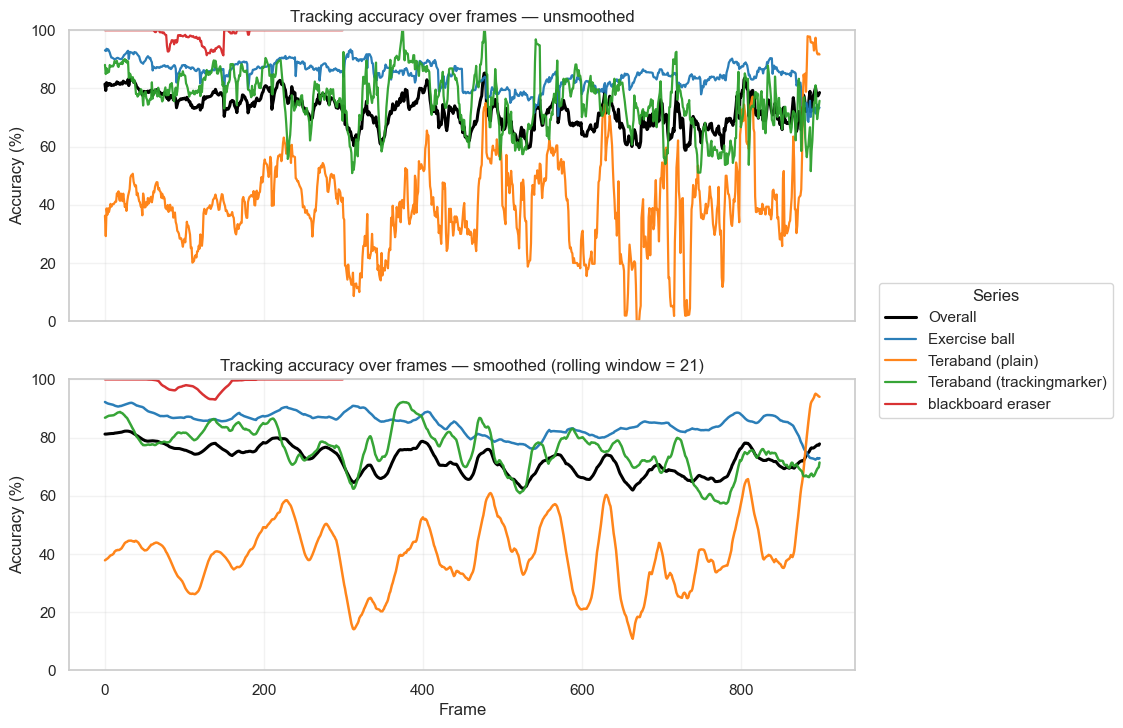

In [59]:
# --- Build per-frame DataFrame from all runs ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except Exception:
    pass

required_cols = {"frame", "accuracy_percent"}
rows = []

if "results" not in globals():
    raise NameError("Variable 'results' not found. Provide it as a list of dicts containing at least 'csv_path' and 'equipment_type'.")

for entry in results:
    csv_path = entry.get("csv_path")
    eq = entry.get("equipment_type")
    analysis_dir = entry.get("analysis_dir", "")

    # derive a run_id from the parent folder of 'analysis'
    # .../<eval_target>/analysis  -> run_id = <eval_target>
    run_id = os.path.basename(os.path.dirname(analysis_dir)) or os.path.basename(analysis_dir)

    if not csv_path or not os.path.isfile(csv_path):
        print(f"[skip] CSV not found: {csv_path}")
        continue

    try:
        tmp = pd.read_csv(
            csv_path,
            usecols=["frame", "accuracy_percent"]  # we only need these two for this plot
        )
    except Exception as e:
        print(f"[skip] Failed reading {csv_path}: {e}")
        continue

    if not required_cols.issubset(tmp.columns):
        print(f"[skip] Missing required cols in {csv_path}: {required_cols - set(tmp.columns)}")
        continue

    tmp = tmp.copy()
    tmp["frame"] = tmp["frame"].astype(int)
    tmp["accuracy_percent"] = tmp["accuracy_percent"].astype(float)
    tmp["equipment_type"] = eq
    tmp["run_id"] = run_id
    rows.append(tmp)

if not rows:
    raise RuntimeError("No CSV data collected. Check 'results' and file paths.")

df_frames = pd.concat(rows, ignore_index=True)
# apply human-readable equipment labels
df_frames["equipment_type"] = df_frames["equipment_type"].map(lambda v: LABEL_MAP.get(v, v))

# --- Aggregate over available runs per absolute frame index ---
# (Different run lengths are naturally handled; higher frames average over fewer runs.)
overall = (
    df_frames
    .groupby("frame")["accuracy_percent"]
    .mean()
    .reset_index()
    .sort_values("frame")
)

by_eq = (
    df_frames
    .groupby(["equipment_type", "frame"])["accuracy_percent"]
    .mean()
    .reset_index()
    .sort_values(["equipment_type", "frame"])
)

# --- Smoothed versions (rolling mean on the aggregated series) ---
def smooth(df, value_col="accuracy_percent", group_cols=None, window=SMOOTH_WINDOW_FRAMES):
    if group_cols is None:
        # single series
        d = df.sort_values("frame").copy()
        d["smoothed"] = d[value_col].rolling(window=window, center=True, min_periods=max(1, window // 3)).mean()
        return d
    else:
        # grouped series (per equipment)
        def _apply(g):
            g = g.sort_values("frame").copy()
            g["smoothed"] = g[value_col].rolling(window=window, center=True, min_periods=max(1, window // 3)).mean()
            return g
        return df.groupby(group_cols, group_keys=False).apply(_apply)

overall_s = smooth(overall, value_col="accuracy_percent", group_cols=None)
by_eq_s   = smooth(by_eq, value_col="accuracy_percent", group_cols=["equipment_type"])

# --- Plot: unsmoothed (top) and smoothed (bottom) ---
eq_list = sorted(df_frames["equipment_type"].unique())
palette = {}
try:
    import seaborn as sns
    colors = sns.color_palette("tab10", n_colors=max(10, len(eq_list)))
except Exception:
    # fallback to Matplotlib default cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if len(colors) < len(eq_list):
        # repeat if too few
        colors = (colors * (len(eq_list) // len(colors) + 1))[:len(eq_list)]
for i, eq in enumerate(eq_list):
    palette[eq] = colors[i % len(colors)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Top: UnsMoothed ---
ax1.plot(overall["frame"], overall["accuracy_percent"], color="black", lw=2.2, label="Overall")
for eq in eq_list:
    g = by_eq[by_eq["equipment_type"] == eq]
    ax1.plot(g["frame"], g["accuracy_percent"], lw=1.6, color=palette[eq], alpha=0.95, label=eq)

ax1.set_ylim(*Y_LIMIT)
ax1.set_ylabel("Accuracy (%)")
ax1.set_title("Tracking accuracy over frames — unsmoothed")
ax1.grid(True, axis="both", alpha=0.25)

# # place legend outside the top axis
# handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=True)

# --- Bottom: Smoothed ---
ax2.plot(overall_s["frame"], overall_s["smoothed"], color="black", lw=2.2, label="Overall (smoothed)")
for eq in eq_list:
    g = by_eq_s[by_eq_s["equipment_type"] == eq]
    ax2.plot(g["frame"], g["smoothed"], lw=1.8, color=palette[eq], alpha=0.95, label=f"{eq}")

ax2.set_ylim(*Y_LIMIT)
ax2.set_xlabel("Frame")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title(f"Tracking accuracy over frames — smoothed (rolling window = {SMOOTH_WINDOW_FRAMES})")
ax2.grid(True, axis="both", alpha=0.25)

# --- Single legend to the RIGHT for both subplots ---
# collect handles/labels from the top axis (avoid duplicates)
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # deduplicate while preserving last

# leave room on the right for the legend panel
fig.subplots_adjust(right=0.78, top=0.90, bottom=0.10)

fig.legend(
    list(by_label.values()),
    list(by_label.keys()),
    loc="center left",
    bbox_to_anchor=(0.80, 0.5),  # just outside the plotting area
    frameon=True,
    title="Series",
    borderaxespad=0.0,
)

plt.show()